In [1]:
import pmdarima as pm
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
from dotenv import load_dotenv
from prophet import Prophet
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
load_dotenv()

True

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Undestanding

In [4]:
df = pd.read_csv('../../transformed_data/cleaned_australian_electricity_demand.csv')
df['ts'] = pd.to_datetime(df['ts'])
df.head()

,ts,series_value
0,2002-01-01 00:00:00,5714.045004
1,2002-01-01 00:30:00,5360.189078
2,2002-01-01 01:00:00,5014.835118
3,2002-01-01 01:30:00,4602.755516
4,2002-01-01 02:00:00,4285.179828


In [5]:
print("Length of the df: ", len(df))

Length of the df:  230736


2308


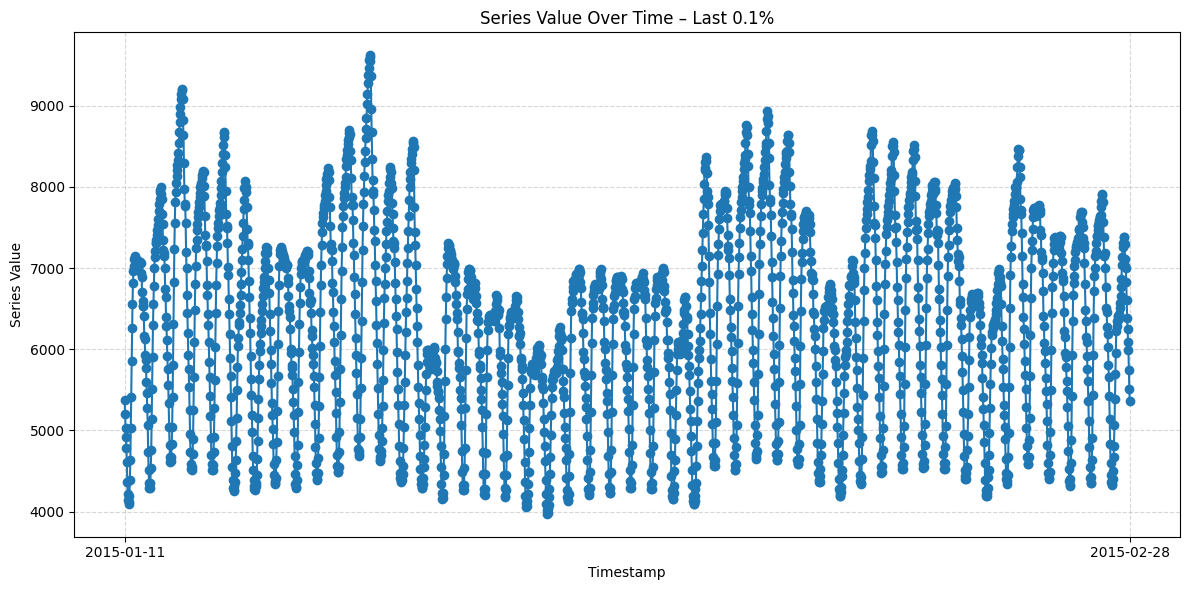

In [6]:
df_short = df[int(len(df) * 0.99):]
print(len(df_short))

start = df_short['ts'].min()
end = df_short['ts'].max()


plt.figure(figsize=(12, 6))
plt.plot(df_short['ts'], df_short['series_value'], marker='o')

# Start and End-Ticks
plt.xticks([start, end], [start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])

plt.xlabel('Timestamp')
plt.ylabel('Series Value')
plt.title('Series Value Over Time – Last 0.1%')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# For test purposes only using most recent 10000 data point!
test_size=48
train_size=9952
df = df.sort_values('ts').reset_index(drop=True)
df_last_10000 = df.tail(10000).copy()

df_train = df_last_10000.iloc[:train_size].copy()
df_test = df_last_10000.iloc[test_size:].copy()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

SyntaxError: invalid character '∏' (U+220F) (2268098417.py, line 6)

# Baseline Model

# ARIMA

In [ ]:
start_arima = time.time()
model = pm.auto_arima(
    df_train['series_value'],
    seasonal=True,    
    stepwise=True,     
    suppress_warnings=True,
    trace=False         
)
end_arima = time.time()

duration_arima = end_arima - start_arima

print("Training Duration: ", duration_arima)

Training Duration:  64.37450194358826


In [ ]:
# Predict
n_periods = test_size
forecast = model.predict(n_periods=n_periods)

y_true = df_test['series_value']

# Evaluation metrics
mae = mean_absolute_error(y_true, forecast)
mape = mean_absolute_percentage_error(y_true, forecast)
rmse = np.sqrt(mean_squared_error(y_true, forecast))

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2159.90
MAPE: 0.3041
RMSE: 2482.54


# LSTM

# Prophet

In [ ]:
# Prepare data for Prophet
df_prophet = df[['ts', 'series_value']].rename(columns={'ts': 'ds', 'series_value': 'y'})

# Split into train and test using the same indices as before
df_train_prophet = df_train[['ts', 'series_value']].rename(columns={'ts': 'ds', 'series_value': 'y'})
df_test_sorted_prophet = df_test[['ts', 'series_value']].rename(columns={'ts': 'ds', 'series_value': 'y'})

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)

start_prophet = time.time()
prophet_model.fit(df_train_prophet)
end_prophet = time.time()
duration_prophet = end_prophet - start_prophet

print('Training duration: ', duration_prophet)

18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing


Training duration:  1.6305649280548096


In [ ]:
# Forecast
future = prophet_model.make_future_dataframe(periods=test_size, freq='30min', include_history=False)
forecast_prophet = prophet_model.predict(future)

# Evaluation
y_pred = forecast_prophet['yhat']
mae_prophet = mean_absolute_error(y_true, y_pred)
mape_prophet = mean_absolute_percentage_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.4f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

Prophet MAE: 8878.41
Prophet MAPE: 1.4357
Prophet RMSE: 11471.95


# TimesFM

# TimeGPT

In [ ]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    api_key=os.getenv('NIXTLA_API_KEY')
)

nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

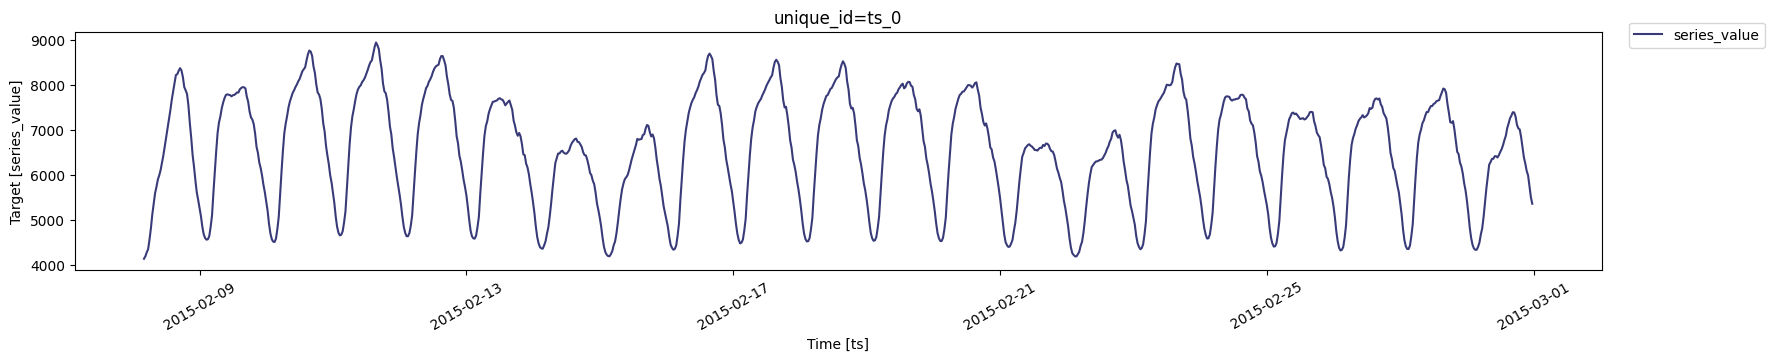

In [ ]:
nixtla_client.plot(df_test, time_col='ts', target_col='series_value')

In [ ]:
print("Duplicates:", df_train['ts'].duplicated().sum())
print("NaNs:\n", df_train.isnull().sum())
print("Frequency check:", df_train['ts'].diff().dropna().value_counts().head())

Duplicates: 0
NaNs:
 ts              0
series_value    0
dtype: int64
Frequency check: ts
0 days 00:30:00    8999
Name: count, dtype: int64


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


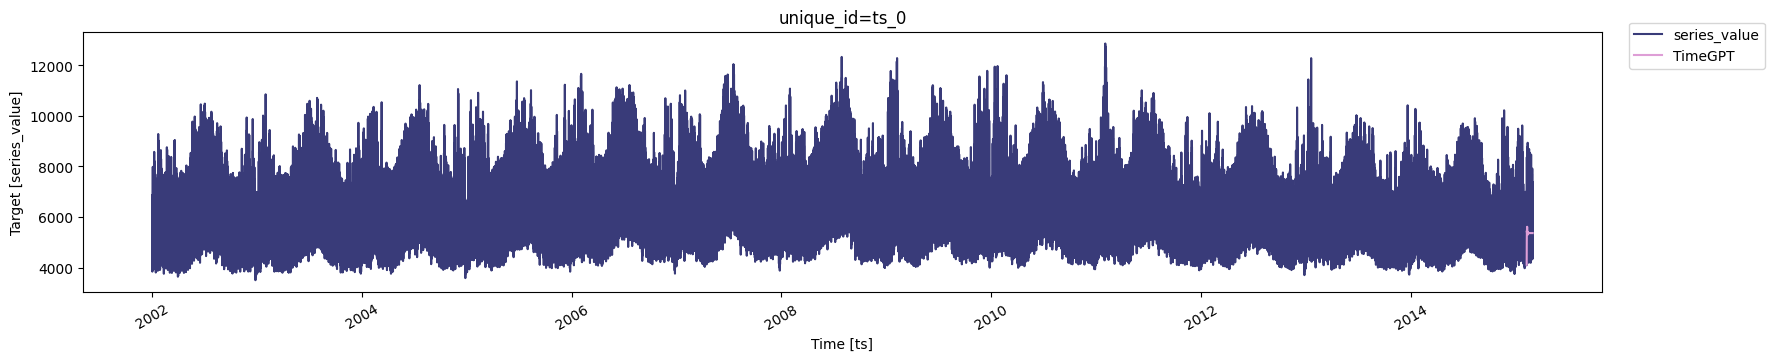

In [ ]:
start_gpt = time.time()
timegpt_fcst_df = nixtla_client.forecast(
    df=df_train,
    h=1000,
    freq='30min',
    time_col='ts',
    target_col='series_value'
)
end_gpt = time.time()
period_gpt = end_gpt - start_gpt
print("Training Period: ", period_gpt)

nixtla_client.plot(df, timegpt_fcst_df, time_col='ts', target_col='series_value')

In [ ]:
# Calculate TimeGPT metrics for the test period
# First 48 predictions from TimeGPT vs first 48 actual values
timegpt_mae = mean_absolute_error(y_true, timegpt_fcst_df['TimeGPT'].values)
timegpt_mape = mean_absolute_percentage_error(y_true, timegpt_fcst_df['TimeGPT'].values)
timegpt_rmse = np.sqrt(mean_squared_error(y_true, timegpt_fcst_df['TimeGPT'].values))

print(f"TimeGPT MAE: {timegpt_mae:.2f}")
print(f"TimeGPT MAPE: {timegpt_mape:.4f}")
print(f"TimeGPT RMSE: {timegpt_rmse:.2f}")

TimeGPT MAE: 1447.85
TimeGPT MAPE: 0.2072
TimeGPT RMSE: 1693.21


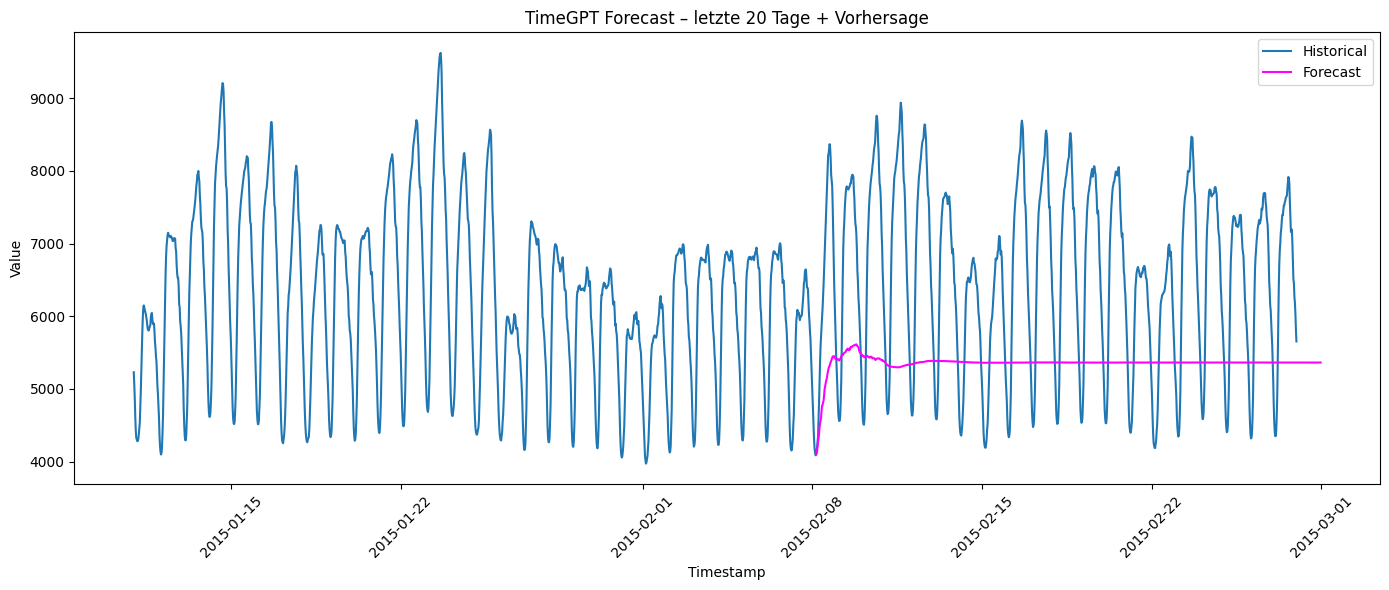

In [ ]:
cutoff = df_train['ts'].max() - pd.Timedelta(days=test_size)

# cutoff bevore 20 days in the past
df_recent = df_train[df_train['ts'] >= cutoff]

plt.figure(figsize=(14, 6))
plt.plot(df_recent['ts'], df_recent['series_value'], label='Historical')
plt.plot(timegpt_fcst_df['ts'], timegpt_fcst_df['TimeGPT'], label='Forecast', color='magenta')
plt.title('TimeGPT Forecast – letzte 20 Tage + Vorhersage')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary

Model Performance Summary:
     Model        MAE    MAPE        RMSE
0    ARIMA  2159.9043  0.3041   2482.5399
1  Prophet  8878.4132  1.4357  11471.9548
2  TimeGPT  1447.8486  0.2072   1693.2131


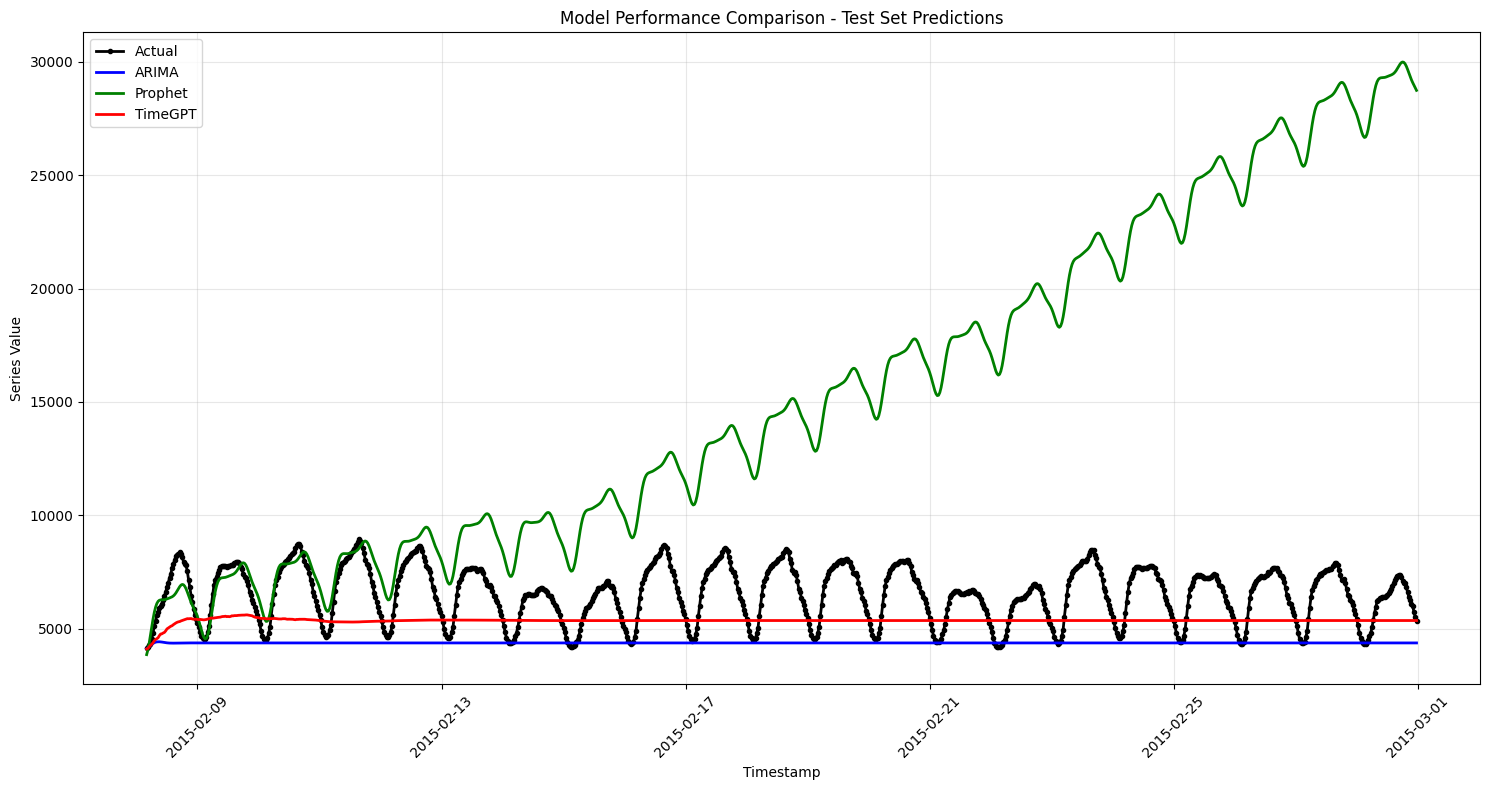


Best performing models:
MAE: TimeGPT
MAPE: TimeGPT
RMSE: TimeGPT


In [ ]:
# Create summary comparison table
results_summary = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'TimeGPT'],
    'MAE': [mae, mae_prophet, timegpt_mae],
    'MAPE': [mape, mape_prophet, timegpt_mape],
    'RMSE': [rmse, rmse_prophet, timegpt_rmse]
})

print("Model Performance Summary:")
print("=" * 50)
print(results_summary.round(4))

# Visualization comparing all three models
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(df_test['ts'], y_true, label='Actual', color='black', linewidth=2, marker='o', markersize=3)

# Plot predictions from all models
plt.plot(df_test['ts'], forecast, label='ARIMA', color='blue', linewidth=2)
plt.plot(df_test['ts'], y_pred, label='Prophet', color='green', linewidth=2)
plt.plot(df_test['ts'], timegpt_fcst_df['TimeGPT'], label='TimeGPT', color='red', linewidth=2)

plt.title('Model Performance Comparison - Test Set Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Series Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Best model identification
best_mae_model = results_summary.loc[results_summary['MAE'].idxmin(), 'Model']
best_mape_model = results_summary.loc[results_summary['MAPE'].idxmin(), 'Model']
best_rmse_model = results_summary.loc[results_summary['RMSE'].idxmin(), 'Model']

# Training time comparison
print(f"ARIMA Training Time: {duration_arima:.2f} seconds")
print(f"Prophet Training Time: {duration_prophet:.2f} seconds")
print(f"TimeGPT Training Time: {period_gpt:.2f} seconds")